In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras_preprocessing.image import ImageDataGenerator


from src.ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCnn_Feit-reduced-rgb-no_inception-weighted_class_loss_paszke"


/home/jelinek/recetox/src/notebooks/MyCNN


In [2]:
import math


class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='same')(inputs)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=256, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=512, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=11, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        # Setting the class weights
        class_weights = {}
        c = 1.02
        for k in data_train.class_indices.values():
            support = len([x for x in data_train.classes if x == k])
            weight = 1.0 / math.log(c + support)
            class_weights[k] = weight

        print("Class weights: ")
        print(class_weights)
        print("***************************")

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()],
                       class_weight=class_weights)

In [15]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

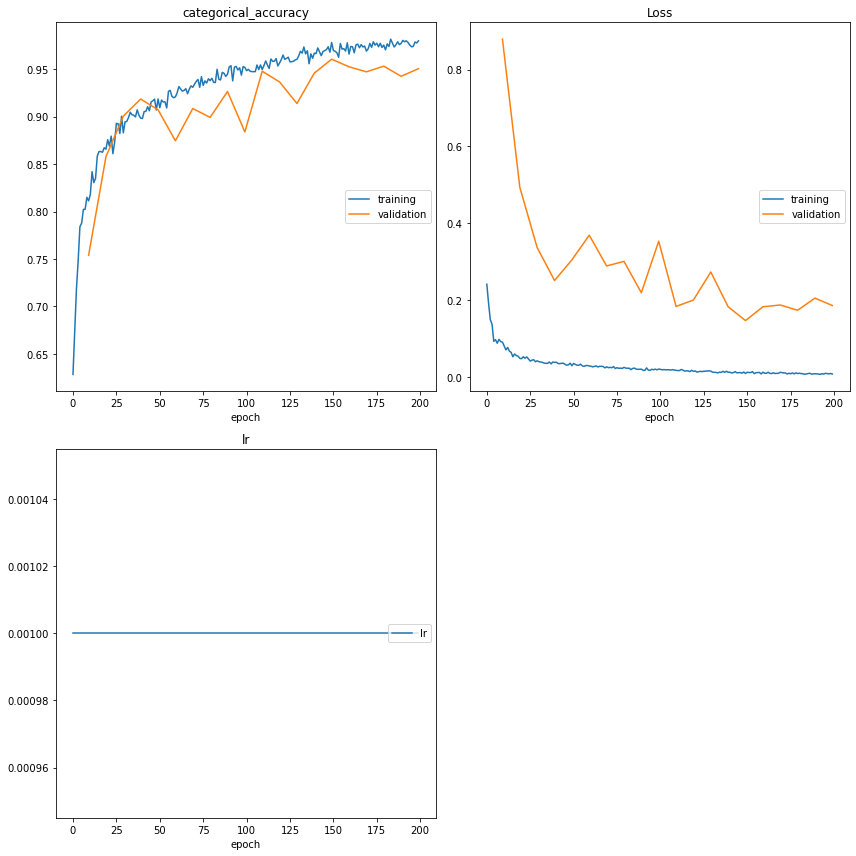

categorical_accuracy
	training         	 (min:    0.628, max:    0.982, cur:    0.980)
	validation       	 (min:    0.754, max:    0.961, cur:    0.951)
Loss
	training         	 (min:    0.007, max:    0.241, cur:    0.008)
	validation       	 (min:    0.147, max:    0.879, cur:    0.186)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
250/250 [==============================] - 19s 78ms/step - loss: 0.0078 - categorical_accuracy: 0.9800 - val_loss: 0.1860 - val_categorical_accuracy: 0.9506 - lr: 0.0010
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.6974ms
Confusion Matrix
[[318   4   1   0   2   0   0   0   0   0  10]
 [  2  47   6   1   0   0   4   4   0   0   0]
 [  1   4 124   1   3   0   3   5   0   0   4]
 [  0   1   0   8   2   0   0   0   0   0   0]
 [  0   0   1   1 542   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   3   1   0   0   0  72   1   0   0   0]
 [  0   0   1   0   0   0   0  85   0   0   0]
 [

In [16]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [17]:
pipeline.save_pipeline()

In [18]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           name,
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1499 images belonging to 11 classes.
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.6719ms
Confusion Matrix
[[318   4   1   0   2   0   0   0   0   0  10]
 [  2  47   6   1   0   0   4   4   0   0   0]
 [  1   4 124   1   3   0   3   5   0   0   4]
 [  0   1   0   8   2   0   0   0   0   0   0]
 [  0   0   1   1 542   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   3   1   0   0   0  72   1   0   0   0]
 [  0   0   1   0   0   0   0  85   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0]
 [  5   0   0   0   2   0   0   0   0   0 227]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.98      0.95      0.96       335
          blood_and_vessels       0.80      0.73      0.76        64
          connective_tissue       0.92      0.86      0.89       145
                      empty       0.73      0.7

In [3]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [4]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)

Processing region 120 out of 120
Post-processing image...
Processing grid point 663499 out of 663499
Processing image took 2042.3936784267426 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no_inception-weighted_class_loss_paszke/ns-adenoca-colon-15071-2019-20x-he-4.tiff
----------------------------------------------------
Processing region 255 out of 255
Post-processing image...
Processing grid point 1599360 out of 1599360
Processing image took 4893.543171167374 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no_inception-weighted_class_loss_paszke/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
----------------------------------------------------
Processing region 255 out of 255
Post-processing image...
Processing grid point 1544036 out of 1544036
Processing image took 4745.614319562912 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no_inception-weighted_class_loss_paszke/ns-adenoca-colon-3043